In [1]:
import torch
import matplotlib.pyplot as plt

In [1]:
# reading the data
words = open("../data/names.txt", "r").read().splitlines()

# Exploring
print(f"first 10 words{words[:10]}")
print(f"length of words: {len(words)}")
print(f"min word length {min(len(w) for (w) in words)} and max word length {max(len(w) for (w) in words)}")

first 10 words['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']
length of words: 32033
min word length 2 and max word length 15


# Bigram
Bigram works with `2` words/characters at a time.

It uses the `previous` word/charachter to predict the `next` word/character. It is a simple model but it is a good starting point to understand the problem.

## 1- Bigram Dictionary

In [3]:
# getting the Bigrams
b = {}
for w in words:
    # add start and end tokens
    chs = ["<S>"] + list(w) + ["<E>"]
    for ch1, ch2 in zip(chs, chs[1:]):
        bigram = (ch1, ch2)
        # print(bigram)

        # use get instead of b[bigram] to avoid KeyError and set default to 0
        b[bigram] = b.get(bigram, 0) + 1

In [4]:
# print the most common bigrams in the data (sort by value)
sorted(b.items(), key = lambda kv: kv[1], reverse = True)[:10]

[(('n', '<E>'), 6763),
 (('a', '<E>'), 6640),
 (('a', 'n'), 5438),
 (('<S>', 'a'), 4410),
 (('e', '<E>'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('<S>', 'k'), 2963)]

## 2- Bigram 2D Tensor

In [5]:
N = torch.zeros(28, 28, dtype = torch.int32)

In [6]:
# make a list of characters (a -> z)
chars = sorted(list(set("".join(words))))

# make a dictionary of character to index
stoi = {ch: i for (i, ch) in enumerate(chars)}
stoi["<S>"] = len(chars)
stoi["<E>"] = len(chars) + 1

# make a dictionary of index to character
itos = {i: ch for (ch, i) in stoi.items()}

In [7]:
# getting the Bigrams
for w in words:
    # add start and end tokens
    chs = ["<S>"] + list(w) + ["<E>"]
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1, ix2] += 1

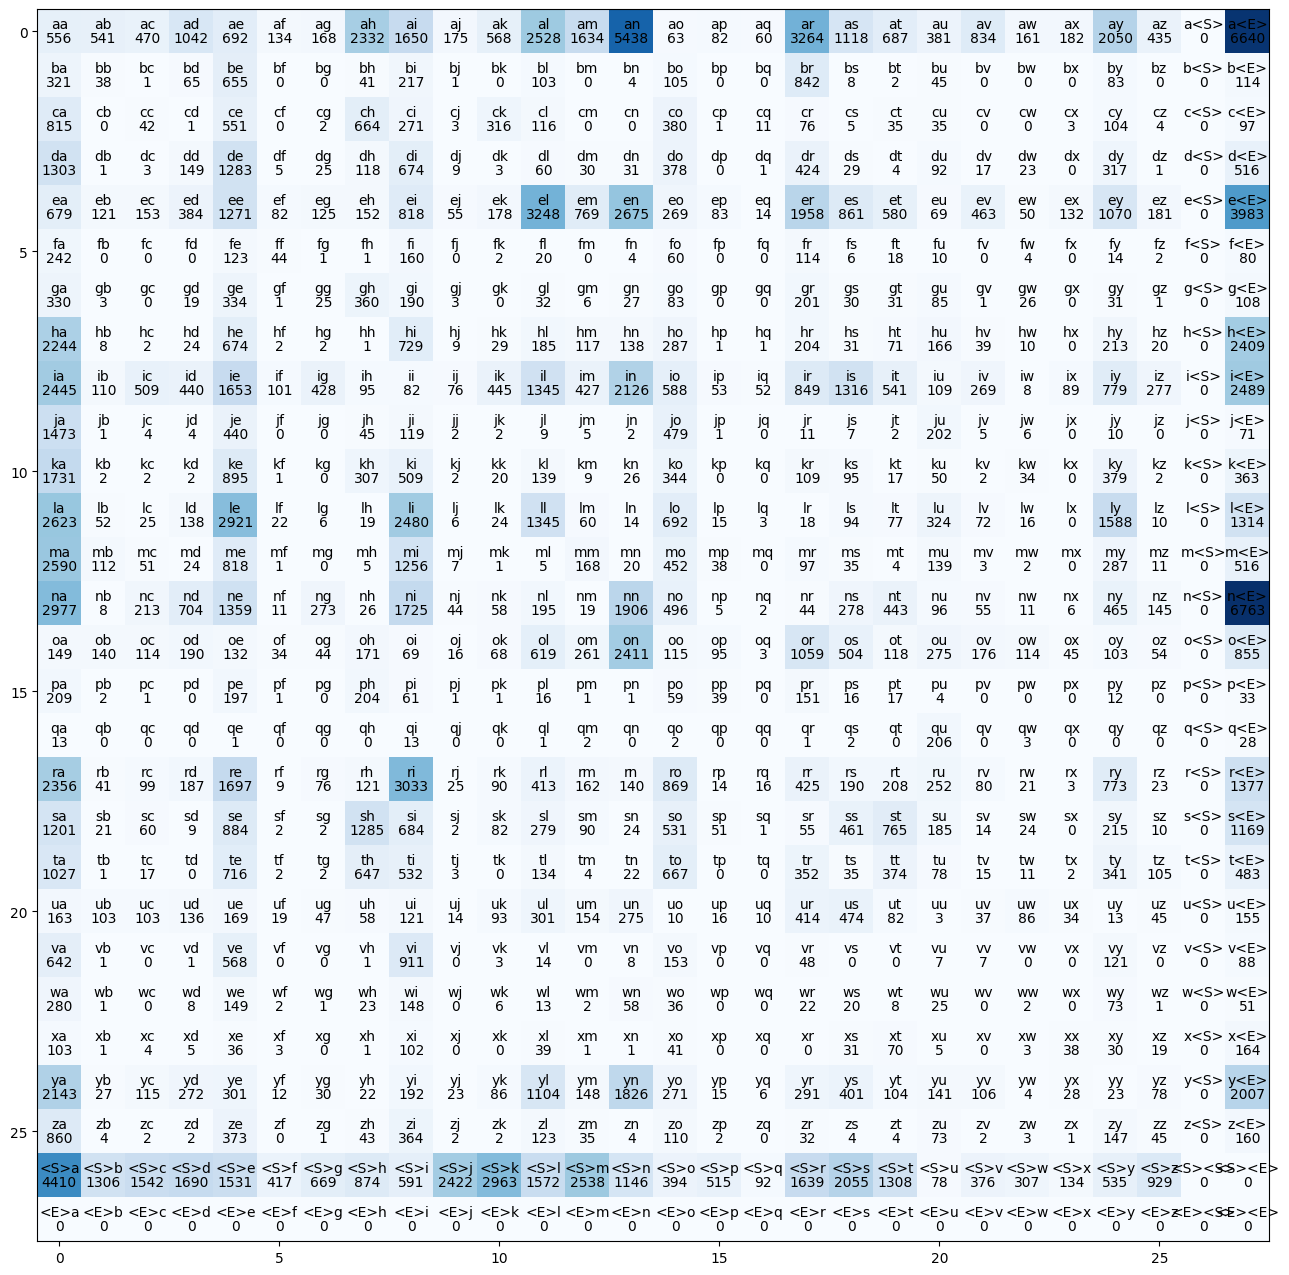

In [8]:
# visualize this matrix
plt.figure(figsize = (16, 16))
plt.imshow(N, cmap = "Blues")
for i in range(28):
    for j in range(28):
        # character strings
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha = "center", va = "bottom", color = "black")
        # bigram counts (.item() converts tensor to int)
        plt.text(j, i, N[i, j].item(), ha = "center", va = "top", color = "black")
plt.show()

### 2.1- Fixing zero row and column problem

notice we have empty `row` and `column` for `<E>` and `<S>` tokens respectively

we will solve that by replacing both of them with `.` token as follows:


``` python
# make a list of characters (a -> z)
chars = sorted(list(set("".join(words))))
# make a dictionary of character to index

stoi = {ch: i for (i, ch) in enumerate(chars)}
# remove theses tokens from the dictionary
```
<strike>

```python
stoi["<S>"] = len(chars)
stoi["<E>"] = len(chars) + 1
```
</strike>

```python
# and add this token
stoi["."] = len(chars)
# make a dictionary of index to character
itos = {i: ch for (ch, i) in stoi.items()}
```

In [9]:
N = torch.zeros(27, 27, dtype = torch.int32)

In [10]:
# make a list of characters (a -> z)
chars = sorted(list(set("".join(words))))

# make a dictionary of character to index
stoi = {ch: i + 1 for (i, ch) in enumerate(chars)}
# 🆕 set start and end tokens to 0
stoi["."] = 0

# make a dictionary of index to character
itos = {i: ch for (ch, i) in stoi.items()}

In [11]:
# getting the Bigrams
for w in words:
    # add start and end tokens
    chs = ["."] + list(w) + ["."]
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1, ix2] += 1

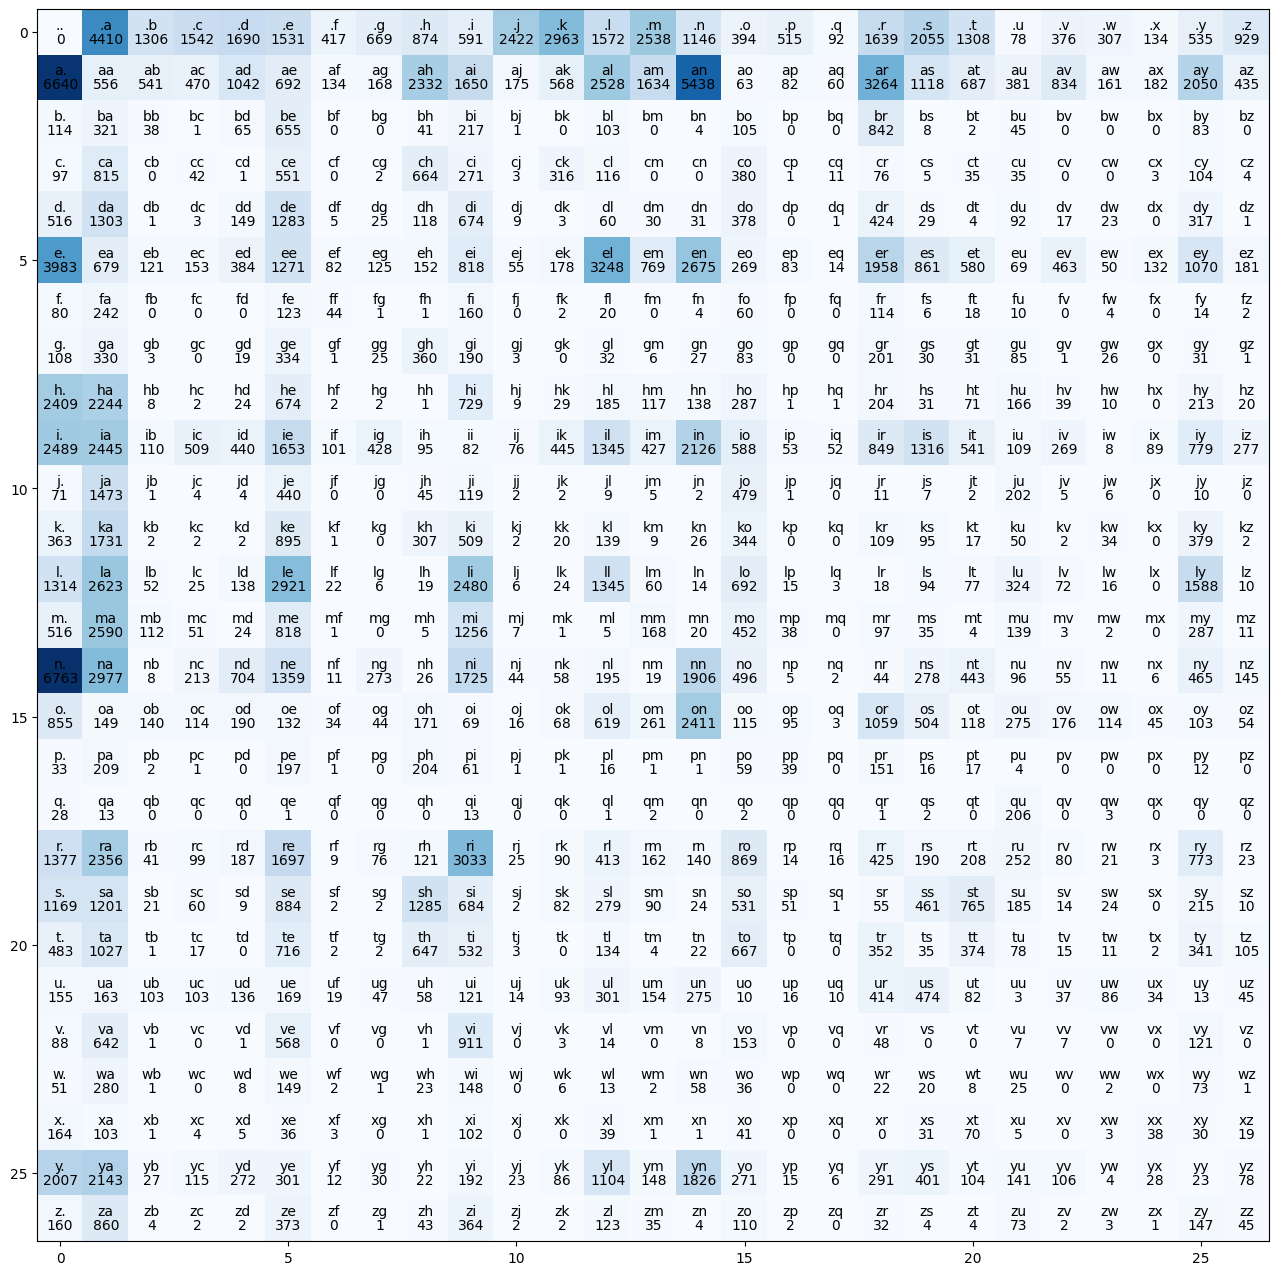

In [12]:
# visualize this matrix
plt.figure(figsize = (16, 16))
plt.imshow(N, cmap = "Blues")
for i in range(27):
    for j in range(27):
        # character strings
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha = "center", va = "bottom", color = "black")
        # bigram counts (.item() converts tensor to int)
        plt.text(j, i, N[i, j].item(), ha = "center", va = "top", color = "black")
plt.show()

notice:
- `..` is `zero`, since we don't have `empty` words
- the first `row` is `start` words
- the first `column` is `end` words

## 3- Sampling from the model

In [13]:
# probability of the first character
p = N[0].float() / N[0].sum()
p

tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])

In [14]:
# probability 
p = N[0].float() / N[0].sum()

# generator is a seed for reproducibility
g = torch.Generator().manual_seed(2147483647)

# sample from the p distribution using the generator (I got different results from Andrej's idk why 🤔🤔)
ix = torch.multinomial(p, num_samples = 1 , replacement = True, generator = g).item()
# convert index to character
itos[ix]

'j'

In [15]:
g = torch.Generator().manual_seed(2147483647)

for i in range(10):
    out = []
    ix = 0
    while True:
        p = N[ix].float() / N[ix].sum()
        ix = torch.multinomial(p, num_samples = 1 , replacement = True, generator = g).item()
        out.append(itos[ix])
        if ix == 0:
            break

    print("".join(out))

junide.
janasah.
p.
cony.
a.
nn.
kohin.
tolian.
juee.
ksahnaauranilevias.


### 3.1- Vectorization of probabilities
instead of calculating it everytime

#### 3.1.1- Broadcasting Example

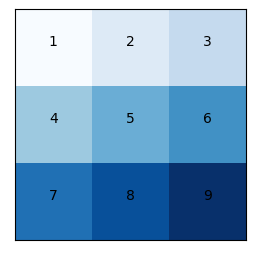

In [16]:
x = torch.tensor([[1,2,3],[4,5,6], [7,8,9]])
# visualize this matrix
plt.figure(figsize = (3, 3))
plt.imshow(x, cmap = "Blues")
for i in range(3):
    for j in range(3):
        # character strings
        chstr = x[i, j].item()
        plt.text(j, i, chstr, ha = "center", va = "bottom", color = "black")
        plt.xticks([])
        plt.yticks([])

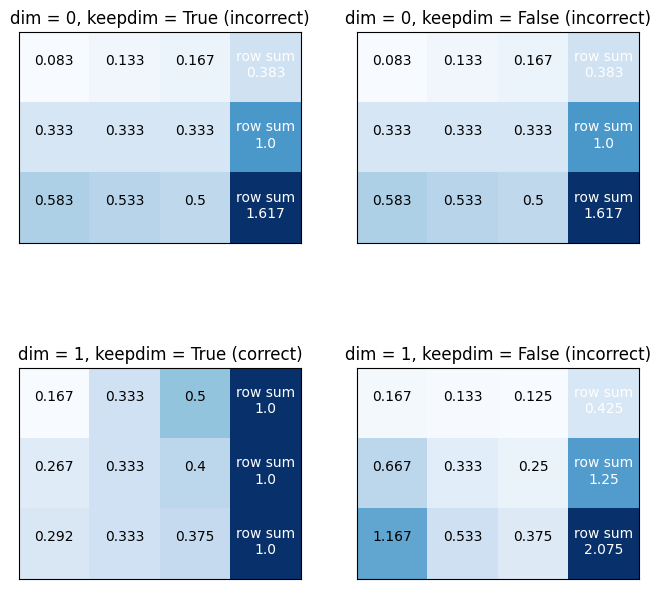

In [17]:
# visualize this matrix
x = torch.tensor([[1,2,3],[4,5,6], [7,8,9]])
xs = [
    torch.cat([(x / x.sum(dim = 0, keepdim = True)), (x / x.sum(dim = 0, keepdim = True)).sum(dim = 1, keepdim = True)], dim = 1), # normalize by column ➡️ incorrect ❌
    torch.cat([(x / x.sum(dim = 0, keepdim = False)), (x / x.sum(dim = 0, keepdim = False)).sum(dim = 1, keepdim = True)], dim = 1), # normalize by column ➡️ incorrect ❌
    torch.cat([(x / x.sum(dim = 1, keepdim = True)), (x / x.sum(dim = 1, keepdim = True)).sum(dim = 1, keepdim = True)], dim = 1), # normalize by row ➡️ correct (sum of each row == 1)✅
    torch.cat([(x / x.sum(dim = 1, keepdim = False)), (x / x.sum(dim = 1, keepdim = False)).sum(dim = 1, keepdim = True)], dim = 1) # normalize by column  ➡️ incorrect ❌
    ]

# visualize this matrices
fig, axes = plt.subplots(2, 2, figsize = (8, 8))
for n in range(4):
    axes[n // 2, n % 2].imshow(xs[n], cmap = "Blues")
    for i in range(3):
        for j in range(4):
            chstr = xs[n][i, j].item()
            if j == 3:
                axes[n // 2, n % 2].text(j, i - 0.25, f"row sum\n{round(chstr, 3)}", ha = "center", va = "top", color = "white")
            else:
                axes[n // 2, n % 2].text(j, i, round(chstr, 3), ha = "center", va = "bottom", color = "black")
            if n // 2 == 0 or not(n % 2 == 0):
                axes[n // 2, n % 2].set_title(f"dim = {n // 2}, keepdim = {not bool(n % 2)} (incorrect)")
            else:
                axes[n // 2, n % 2].set_title(f"dim = {n // 2}, keepdim = {not bool(n % 2)} (correct)")

            # remove ticks
            axes[n // 2, n % 2].set_xticks([])
            axes[n // 2, n % 2].set_yticks([])

#### 3.1.2- Vectorization

Wrong boradcasting Example:
```python
P = N.float() / N.sum(dim = 1, keepdim = False)
# Broadcasting:
# N.sum(dim = 1) ➡️ (27) ➡️ (1, 27) it became a row vector ❌
# N.float() ➡️ (27, 27)
# P ➡️ (27, 27)
# Wrong ❌ sum of each row != 1
```

In [18]:
P = N.float() / N.sum(dim = 1, keepdim = True)
# Broadcasting:
# N.sum(dim = 1, keepdim = True) ➡️ (27, 1)
# N.float() ➡️ (27, 27)
# P ➡️ (27, 27)
# Correct ✅ sum of each row == 1

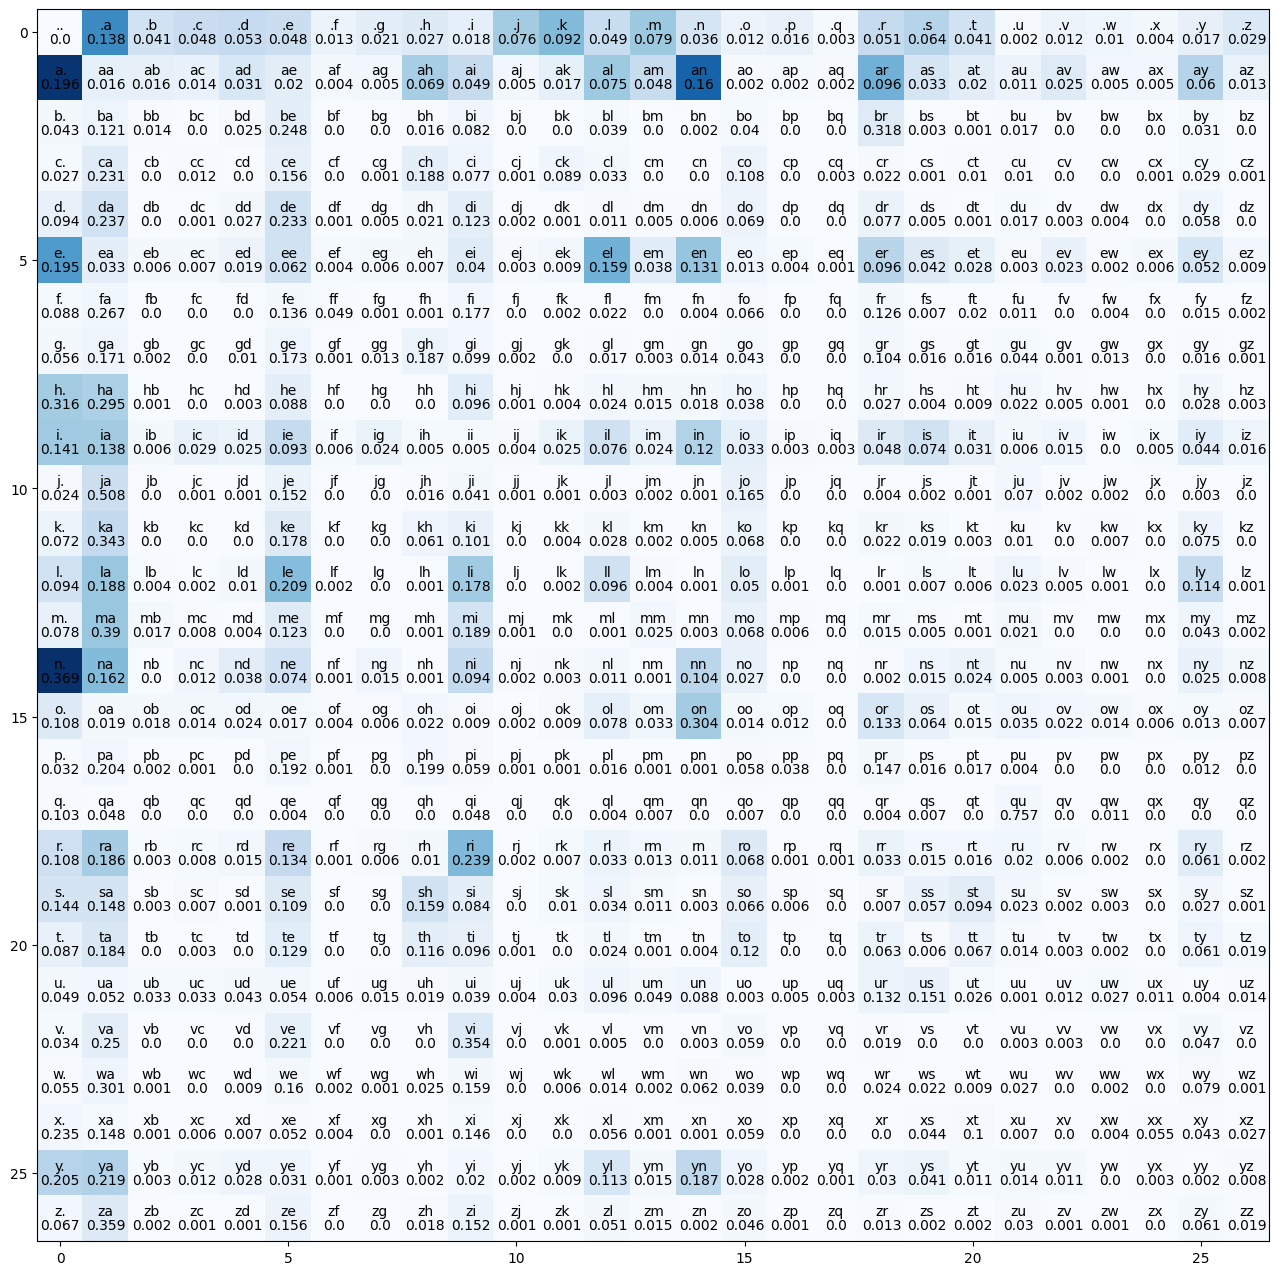

In [19]:
# visualize this probability matrix, it matches the bigram matrix
plt.figure(figsize = (16, 16))
plt.imshow(N, cmap = "Blues")
for i in range(27):
    for j in range(27):
        # character strings
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha = "center", va = "bottom", color = "black")
        # bigram counts (.item() converts tensor to int)
        plt.text(j, i, round(P[i, j].item(),3), ha = "center", va = "top", color = "black")
plt.show()

In [20]:
# sample from P
names = []
g = torch.Generator().manual_seed(2147483647)

for i in range(10):
    out = []
    ix = 0
    while True:
        p = P[ix]
        ix = torch.multinomial(p, num_samples = 1 , replacement = True, generator = g).item()
        out.append(itos[ix])
        if ix == 0:
            break

    names.append("".join(out))
print(names)

['junide.', 'janasah.', 'p.', 'cony.', 'a.', 'nn.', 'kohin.', 'tolian.', 'juee.', 'ksahnaauranilevias.']


## 4- Training Loss: NLL

In [21]:
# getting the Bigrams
for w in words[:3]:
    # add start and end tokens
    chs = ["."] + list(w) + ["."]
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        # probability of each bigram
        # should be 1/27 = 0.037 for a uniform distribution i.e., random guessing
        prob = P[ix1, ix2]
        print(f"{ch1}{ch2} -> {prob:.4f}")

.e -> 0.0478
em -> 0.0377
mm -> 0.0253
ma -> 0.3899
a. -> 0.1960
.o -> 0.0123
ol -> 0.0780
li -> 0.1777
iv -> 0.0152
vi -> 0.3541
ia -> 0.1381
a. -> 0.1960
.a -> 0.1377
av -> 0.0246
va -> 0.2495
a. -> 0.1960


we need a single number to combine all of these probabilities and measure the quality of the model ➡️ `Maximum Likelihood Estimation`

so, the `product of all probabilities` == the `sum of log of all probabilities` ➡️ should be as `high as possible`

In [22]:
# for smoothing (to prevent zero probabilities = log(0) = -inf)
P = (N+1).float() / N.sum(dim = 1, keepdim = True)

In [23]:
def nll_loss(input_list, verbose = False):
    log_likelihood = 0.0
    n = 0
    for w in input_list:
        # add start and end tokens
        chs = ["."] + list(w) + ["."]
        for ch1, ch2 in zip(chs, chs[1:]):
            ix1 = stoi[ch1]
            ix2 = stoi[ch2]
            # probability of each bigram
            # should be 1/27 = 0.037 for a uniform distribution i.e., random guessing
            prob = P[ix1, ix2]
            logprob = torch.log(prob)
            log_likelihood += logprob
            n += 1
            # higher the log probability (closer to 0) is better
            if verbose:
                print(f"{ch1}{ch2} -> {prob:.4f} {logprob:.4f}")

    # higher the log likelihood (closer to 0) is better
    print(f"log Likelihood: {log_likelihood}")

    # but in loss function lower is better, so we negate it
    nll = -log_likelihood
    print(f"Negative log likelihood: {nll}")

    # normalize it
    print(f"Normalized Negative log Likelihood: {(nll / n)}") # we need to minimize this

nll_loss(words[:5], verbose = True)

.e -> 0.0478 -3.0402
em -> 0.0377 -3.2780
mm -> 0.0254 -3.6713
ma -> 0.3901 -0.9414
a. -> 0.1960 -1.6297
.o -> 0.0123 -4.3956
ol -> 0.0781 -2.5492
li -> 0.1777 -1.7274
iv -> 0.0153 -4.1830
vi -> 0.3545 -1.0372
ia -> 0.1382 -1.9792
a. -> 0.1960 -1.6297
.a -> 0.1377 -1.9827
av -> 0.0246 -3.7033
va -> 0.2499 -1.3867
a. -> 0.1960 -1.6297
.i -> 0.0185 -3.9910
is -> 0.0744 -2.5983
sa -> 0.1483 -1.9086
ab -> 0.0160 -4.1355
be -> 0.2480 -1.3943
el -> 0.1591 -1.8383
ll -> 0.0964 -2.3389
la -> 0.1880 -1.6714
a. -> 0.1960 -1.6297
.s -> 0.0642 -2.7460
so -> 0.0656 -2.7237
op -> 0.0121 -4.4146
ph -> 0.1998 -1.6104
hi -> 0.0959 -2.3450
ia -> 0.1382 -1.9792
a. -> 0.1960 -1.6297
log Likelihood: -77.71862030029297
Negative log likelihood: 77.71862030029297
Normalized Negative log Likelihood: 2.4287068843841553


In [24]:
# check the loss of the sample names
nll_loss(names)

log Likelihood: -256.8978576660156
Negative log likelihood: 256.8978576660156
Normalized Negative log Likelihood: 3.471592664718628


for first training example: `.emma.`: the nll is `2.512`

for the first 5 training exampless: the average nll is `2.429`

# MLP Approach

## 1- Training set of bigrams (x,y)

In [25]:
xs , ys = [], []

for w in words:
    # add start and end tokens
    chs = ["."] + list(w) + ["."]
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)

# convert to tensors
xs = torch.tensor(xs)
ys = torch.tensor(ys)

# first word: 5 separate examples (.emma ➡️ emma.)
print(xs[:5])
print(ys[:5])

tensor([ 0,  5, 13, 13,  1])
tensor([ 5, 13, 13,  1,  0])


## 2- One-hot encoding

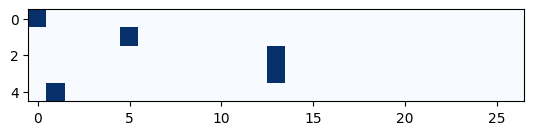

In [26]:
import torch.nn.functional as F
# you have to cast to float for one_hot (doesn't accept dtype parameter)
xenc = F.one_hot(xs, num_classes = 27).float()
plt.imshow(xenc[:5], cmap = "Blues")

## 3- define the network

### 3.1- one output neuron ➡️ single outputs for each example

In [27]:
W = torch.randn((27,1))
# apply matrix multiplication (dot product): (5, 27) @ (27, 1) = (5, 1)
xenc[:5] @ W

tensor([[ 2.0649],
        [ 0.3973],
        [-0.4084],
        [-0.4084],
        [-0.7026]])

### 3.2 - 27 output neurons ➡️ 27 output neurons for each character

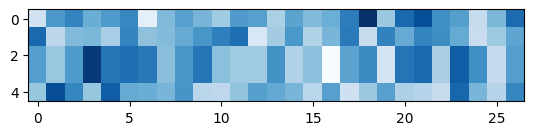

In [28]:
W = torch.randn((27,27), requires_grad = True)
# apply matrix multiplication (dot product): (5, 27) @ (27, 27) = (5, 27)
xenc[:5] @ W
plt.imshow(xenc[:5] @ W.detach().numpy(), cmap = "Blues")

## 4- Gradient Descent

In [29]:
W = torch.randn((27,27), requires_grad = True)

In [30]:
# forward pass

# log-counts
logits = xenc @ W 
# exp them ➡️ counts
counts = torch.exp(logits)
# convert them into probabilities
probs = counts / counts.sum(dim = 1, keepdim = True)

# # the previous 3 lines can be replaced by:
# probs = F.softmax(logits, dim = 1)

loss = - probs[torch.arange(5), ys[:5]].log().mean()

In [31]:
loss.item()

3.2675838470458984

In [32]:
# backward pass
# set gradients to zero
W.grad = None
loss.backward()

# update weights
with torch.no_grad():
    W -= 0.1 * W.grad

xs[:5]=tensor([ 0,  5, 13, 13,  1])
ys[:5]=tensor([ 5, 13, 13,  1,  0])


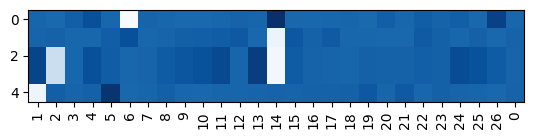

In [33]:
print(f"{xs[:5]=}")
print(f"{ys[:5]=}")
# The effect of all gradients are positive (increasing the loss) except for the correct one is negative (decreasing the loss)
plt.imshow(W.grad.detach().numpy()[xs[:5]], cmap = "Blues")
plt.xticks(range(27), itos, rotation = 90);

## 5- Combine the forward and backward pass into a single function

In [34]:
W = torch.randn((27,27), requires_grad = True)

In [35]:
for k in range(100):
    # forward pass
    xenc = F.one_hot(xs, num_classes = 27).float()
    logits = xenc @ W
    counts = torch.exp(logits)
    probs = counts / counts.sum(dim = 1, keepdim = True)
    
    # loss
    loss = - probs[torch.arange(len(xs)), ys].log().mean()
    # add regularization
    loss += 0.1 * W.pow(2).mean()

    print(f"{k}: {loss.item():.4f}")

    # backward pass
    W.grad = None
    loss.backward()

    # update weights
    with torch.no_grad():
        W -= 50 * W.grad

0: 3.8776
1: 3.5022
2: 3.2583
3: 3.1035
4: 2.9996
5: 2.9234
6: 2.8669
7: 2.8243
8: 2.7914
9: 2.7653
10: 2.7441
11: 2.7267
12: 2.7120
13: 2.6995
14: 2.6887
15: 2.6793
16: 2.6710
17: 2.6637
18: 2.6573
19: 2.6515
20: 2.6463
21: 2.6417
22: 2.6375
23: 2.6338
24: 2.6304
25: 2.6273
26: 2.6245
27: 2.6220
28: 2.6197
29: 2.6176
30: 2.6156
31: 2.6139
32: 2.6122
33: 2.6107
34: 2.6093
35: 2.6080
36: 2.6068
37: 2.6057
38: 2.6046
39: 2.6037
40: 2.6028
41: 2.6019
42: 2.6011
43: 2.6004
44: 2.5996
45: 2.5990
46: 2.5984
47: 2.5978
48: 2.5972
49: 2.5967
50: 2.5962
51: 2.5957
52: 2.5953
53: 2.5949
54: 2.5945
55: 2.5941
56: 2.5937
57: 2.5934
58: 2.5931
59: 2.5928
60: 2.5925
61: 2.5922
62: 2.5919
63: 2.5917
64: 2.5915
65: 2.5912
66: 2.5910
67: 2.5908
68: 2.5906
69: 2.5904
70: 2.5903
71: 2.5901
72: 2.5899
73: 2.5898
74: 2.5896
75: 2.5895
76: 2.5894
77: 2.5892
78: 2.5891
79: 2.5890
80: 2.5889
81: 2.5888
82: 2.5887
83: 2.5886
84: 2.5885
85: 2.5884
86: 2.5883
87: 2.5882
88: 2.5882
89: 2.5881
90: 2.5880
91: 2.588

we are expecting loss similar to the training example (about 2.5)

## 6- Sampling from the model

In [36]:
# sample from P
g = torch.Generator().manual_seed(2147483647)

for i in range(10):
    out = []
    ix = 0
    while True:
        # previosly we used P[ix]
        p = P[ix]

        # now we use the softmax of the logits
        # xenc = F.one_hot(torch.tensor([ix]), num_classes = 27).float()
        # logits = xenc @ W
        # counts = torch.exp(logits)
        # p = counts / counts.sum(dim = 1, keepdim = True)

        ix = torch.multinomial(p, num_samples = 1 , replacement = True, generator = g).item()
        out.append(itos[ix])
        if ix == 0:
            break

    print("".join(out))

junide.
janasah.
p.
cony.
a.
nn.
kohin.
tolian.
juee.
ksahnaauranilevias.


In [37]:
# sample from MLP
g = torch.Generator().manual_seed(2147483647)

for i in range(10):
    out = []
    ix = 0
    while True:
        # previosly we used P[ix]
        # p = P[ix]

        # now we use the softmax of the logits
        xenc = F.one_hot(torch.tensor([ix]), num_classes = 27).float()
        logits = xenc @ W
        counts = torch.exp(logits)
        p = counts / counts.sum(dim = 1, keepdim = True)

        ix = torch.multinomial(p, num_samples = 1 , replacement = True, generator = g).item()
        out.append(itos[ix])
        if ix == 0:
            break

    print("".join(out))

junide.
janaqah.
p.
cfay.
a.
nn.
kohin.
tolian.
jgee.
ksahnaauvinilevias.


The results are `the same`, since we're using the `same model` with the same loss

`W` is the `log counts` (estimated before from the bigram model)